In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
MAIN_IMAGE_PATH = 'image/img2.jpg'
CROP_IMAGE_PATH = 'croped/img2_croped.jpg'

In [4]:
def get_skin_chroma(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    return Cr.astype(np.float32), Cb.astype(np.float32)

In [5]:
def train_skin_model_from_crop(crop_img):
    x, y = get_skin_chroma(crop_img)
    x_flat = x.flatten()
    y_flat = y.flatten()
    
    data = np.vstack((x_flat, y_flat))
    
    mean_vector = np.mean(data, axis=1)
    covariance_matrix = np.cov(data)
    return mean_vector, covariance_matrix

In [6]:
def detect_skin(img, mean, cov):
    x, y = get_skin_chroma(img)
    h, w = x.shape
    
    pixel_data = np.dstack((x, y)).reshape(-1, 2)
    inv_cov = np.linalg.inv(cov)
    diff = pixel_data - mean
    
    dist = np.sqrt(np.sum(np.dot(diff, inv_cov) * diff, axis=1))
    dist_map = dist.reshape(h, w)
    
    mask = dist_map < 3.0
    
    binary_mask = mask.astype(np.uint8) * 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return binary_mask

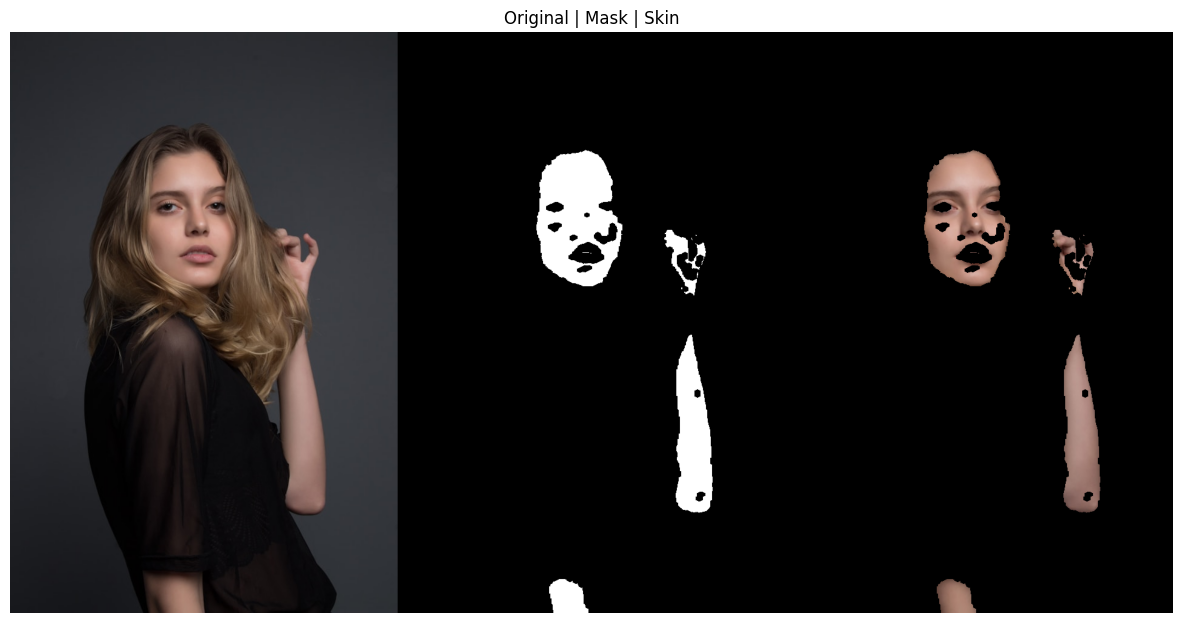

In [10]:
main_img = cv2.imread(MAIN_IMAGE_PATH)
skin_crop = cv2.imread(CROP_IMAGE_PATH)

if main_img is None or skin_crop is None:
    print("Error loading images.")
else:
    mean, cov = train_skin_model_from_crop(skin_crop)
    
    mask_result = detect_skin(main_img, mean, cov)
    
    mask_3ch = cv2.cvtColor(mask_result, cv2.COLOR_GRAY2BGR)
    extracted_skin = cv2.bitwise_and(main_img, main_img, mask=mask_result)
    combined = np.hstack((main_img, mask_3ch, extracted_skin))
    
    # Convert BGR to RGB for matplotlib display
    combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 8))
    plt.imshow(combined_rgb)
    plt.axis('off')
    plt.title("Original | Mask | Skin")
    plt.show()